In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pylab inline
import bq
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


/afs/cern.ch/user/k/kostams/Virualenv/ipython/lib/python2.7/site-packages/Crypto/Util/number.py:57: PowmInsecureWarning: Not using mpz_powm_sec.  You should rebuild using libgmp >= 5 to avoid timing attack vulnerability.
  _warn("Not using mpz_powm_sec.  You should rebuild using libgmp >= 5 to avoid timing attack vulnerability.", PowmInsecureWarning)


In [26]:
import seaborn as s
from matplotlib.colors import LogNorm
s.set(rc={'image.cmap': "jet"})
figsize(12,10)
rcParams['figure.facecolor'] = (1,1,1,1)
rcParams['savefig.facecolor'] = (1,1,1,1)
rcParams['savefig.dpi'] = 100

In [4]:
# Masses
mp = 0.9382
md = 1.8756 

In [5]:
def plot_matrix(frame, **args):
    from matplotlib.colors import LogNorm
    x,y = np.meshgrid(np.array(frame.index,   dtype=float),
                      np.array(frame.columns, dtype=float))
    z = frame.T.values.astype(float)
    ret = gca().pcolor(y,x,z, **args)
    (lambda x: xlim(x[0],x[-1]))(frame.columns)
    (lambda x: ylim(x[0],x[-1]))(frame.index  ) 
    return ret

In [6]:
client = bq.Client.Get()

In [7]:
from histQueryFactory import *

In [8]:
schema = client.GetTableSchema({
    'projectId': 'ams-test-kostya', 
    'datasetId': 'AMS',  
    'tableId': 'protonsB1034'
})

bitFields = None
for field in schema['fields']:
    if field['name'] != 'selStatus': 
        continue
    bitFields = field['description'].split(',')
    break
    
get_cumulative_mask = lambda sel: (1 << (bitFields.index(sel))) - 1

In [24]:
def build_frames(frames, table):
    for v in[ ("1/R",0,2,100, "invR"),
              ("EdepTRD",0,200,200, "EdepTRD"), 
              ("EdepTOF_0+EdepTOF_1+EdepTOF_2+EdepTOF_3",0,40,100, "EdepTOF"),
              ("EdepTrack",0,1000,100, "EdepTrack") ]:
        h = HistQueryFactory(table=table)
        h.add_variable(*v)
        h.add_variable("1/BetaTOF",0.5,2.0,100, 'ib')

        #h.add_condition("selStatus&{0}={0}".format(get_cumulative_mask('aRing')))
        h.add_condition("unusedLayers==0")

        tableid = client.Query(str(h))['configuration']['query']['destinationTable']
        bq_table = client.ReadTableRows(tableid)

        frames[v[-1]] = pd.DataFrame(bq_table, columns=h.get_variables()+['Counts']).astype(float)

def plot_frames(frames):
    from matplotlib.colors import LogNorm
    s.set(rc={'image.cmap': "jet"})
    for n, k in enumerate(frames):
        subplot(2,2,n+1,)
        frame = frames[k]
        frame = frame.set_index(list(frame.columns[:-1])).unstack().fillna(0)['Counts']
        frame /= frame.sum(axis=0)
        plot_matrix(frame, norm=LogNorm(vmin=10**(-5),vmax=1))
        xlabel("1/BetaTOF")
        ylabel(k)

In [21]:
framesMC, framesData = {}, {}
build_frames(framesMC,   "AMS.protonsB1034")
build_frames(framesData, "AMS.Data")

Waiting on bqjob_r64772f2a81b6f271_0000014ed08e6832_9 ... (0s) Current status: DONE   
Waiting on bqjob_r94b8035ed20aeca_0000014ed08e7577_10 ... (0s) Current status: DONE   
Waiting on bqjob_r5fb52b747a4cced5_0000014ed08e8485_11 ... (0s) Current status: DONE   
Waiting on bqjob_r1fbb85815bffed9e_0000014ed08e9070_12 ... (0s) Current status: DONE   
Waiting on bqjob_r6e7a3a9e62c857a1_0000014ed08e9c1c_13 ... (0s) Current status: DONE   
Waiting on bqjob_r170f5b5f8384a913_0000014ed08ead07_14 ... (1s) Current status: DONE   
Waiting on bqjob_r76ba8573f8f8ebcb_0000014ed08ec538_15 ... (2s) Current status: DONE   
Waiting on bqjob_r20354c7317260da0_0000014ed08ee110_16 ... (1s) Current status: DONE   


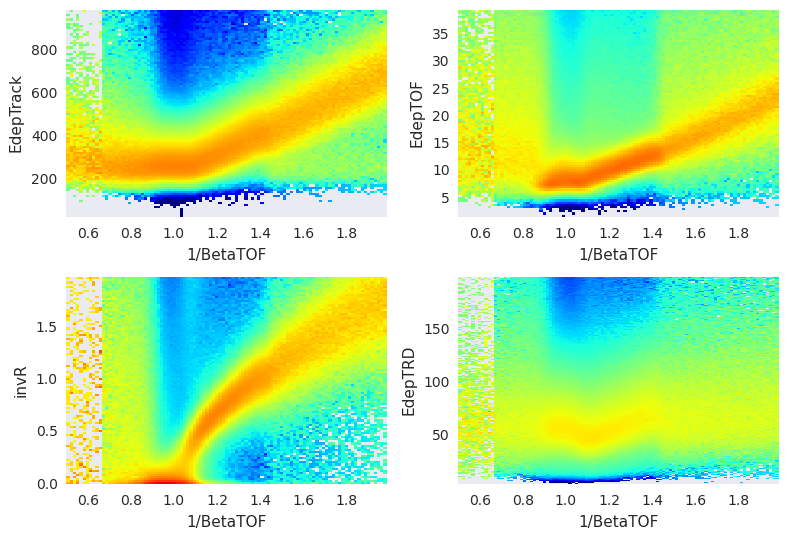

In [27]:
figsize(24,)
plot_frames(framesMC)
tight_layout()

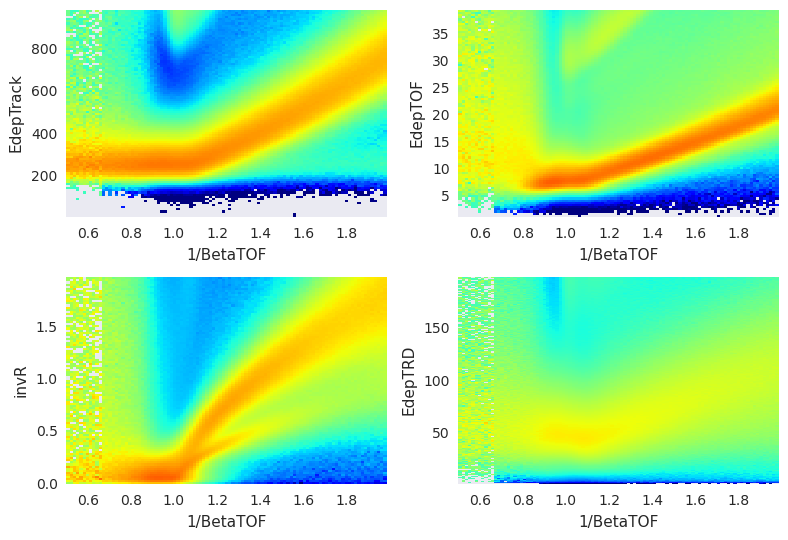

In [29]:
figsize(12,8)
plot_frames(framesData)
tight_layout()

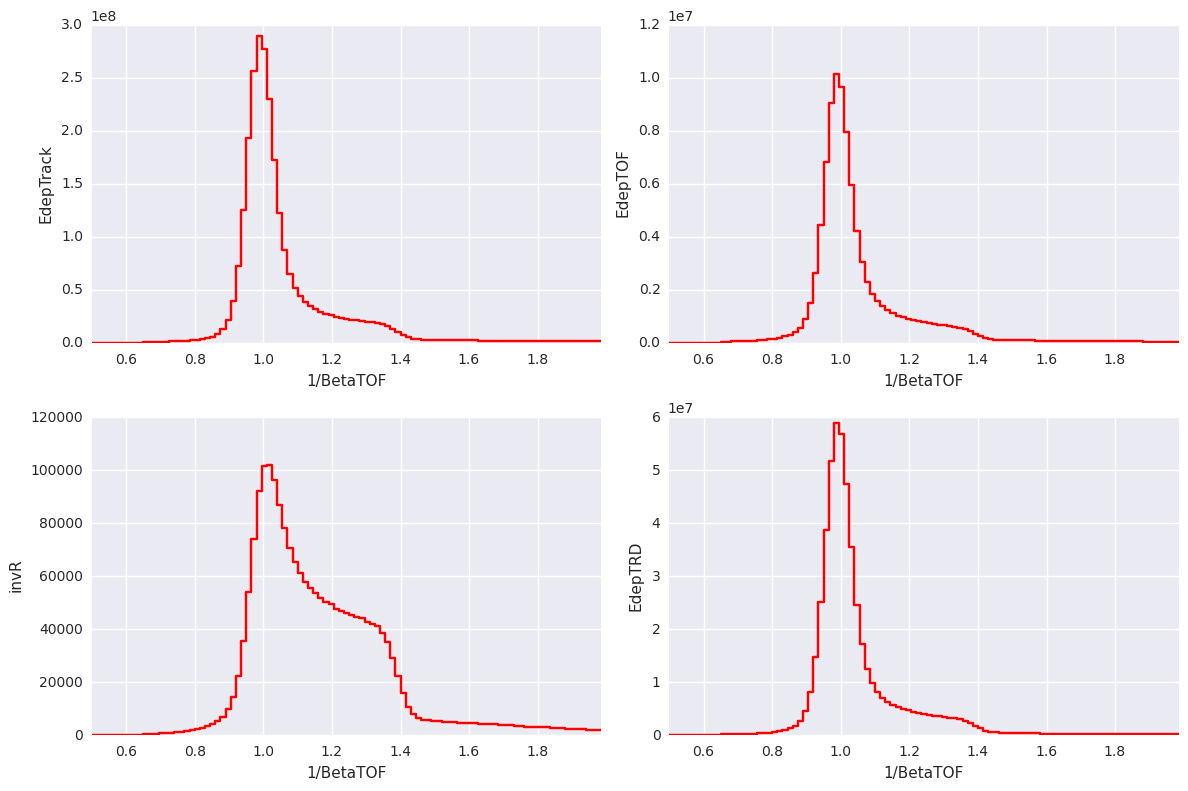

In [14]:
from matplotlib.colors import LogNorm
s.set(rc={'image.cmap': "Blues"})
figsize(12,8)

for n, k in enumerate(frames):
    subplot(2,2,n+1,)
    frame = frames[k]
    frame = frame.set_index(list(frame.columns[:-1])).unstack().fillna(0)['Counts']
    #frame /= frame.sum(axis=0)
    
    #plot_matrix(frame), #norm=LogNorm(vmin=10**(-5),vmax=1))
    
    mean = frame.mul(pd.Series(frame.index,frame.index), axis=0).sum(axis=0)
    std = frame.mul((pd.Series(frame.index,frame.index))**2, axis=0).sum(axis=0)
    std = np.sqrt((std-mean**2))
    
    mean.plot(style='r', drawstyle='steps')   
    (mean+std).plot(style='y', drawstyle='steps-post')
    (mean-std).plot(style='y', drawstyle='steps-post')
    
    xlabel("1/BetaTOF")
    ylabel(k)
    
tight_layout()

In [31]:
framesMC = {f:frames[f].copy() for f in frames}

In [32]:
frames = {}
for v in[
    ("1/R",0,2,100, "invR"),
    ("EdepTRD",0,200,200, "EdepTRD"), 
    ("EdepTOF_0+EdepTOF_1+EdepTOF_2+EdepTOF_3",0,40,100, "EdepTOF"),
    ("EdepTrack",0,1000,100, "EdepTrack"),
]:

    
    h = HistQueryFactory(table=build_frames(framesMC, "AMS.protonsB1034"))
    h.add_variable(*v)
    h.add_variable("1/BetaTOF",0.5,2.0,100, 'ib')

    #h.add_condition("selStatus&{0}={0}".format(get_cumulative_mask('aRing')))
    h.add_condition("unusedLayers==0")

    tableid = client.Query(str(h))['configuration']['query']['destinationTable']
    bq_table = client.ReadTableRows(tableid)

    frames[v[-1]] = pd.DataFrame(bq_table, columns=h.get_variables()+['Counts']).astype(float)

Waiting on bqjob_r4ef52a429c555fe4_0000014eb61cdf25_26 ... (0s) Current status: DONE   
Waiting on bqjob_r30282f6d512ce417_0000014eb61ce93b_27 ... (0s) Current status: DONE   
Waiting on bqjob_r3aa2a7bf1216a085_0000014eb61cf39f_28 ... (0s) Current status: DONE   
Waiting on bqjob_r349d5643e34d0c26_0000014eb61cfc0c_29 ... (0s) Current status: DONE   


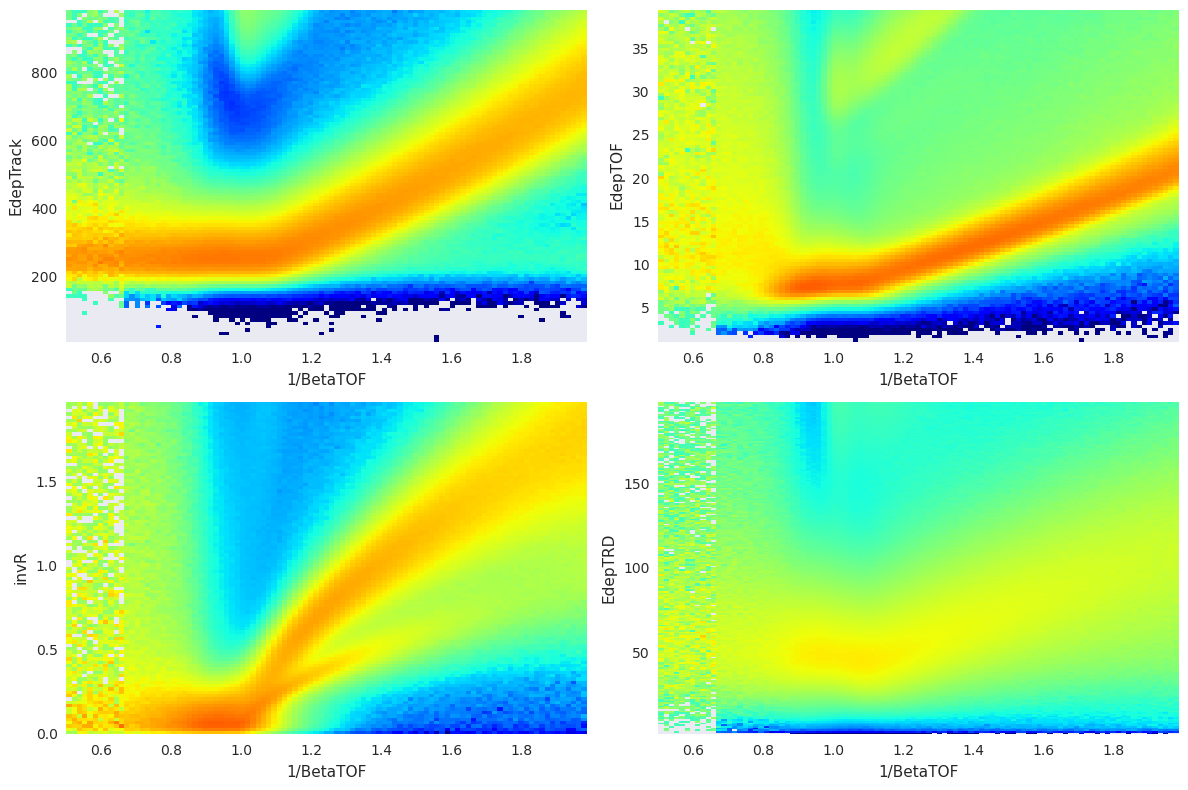

In [33]:
from matplotlib.colors import LogNorm
s.set(rc={'image.cmap': "jet"})
figsize(12,8)

for n, k in enumerate(frames):
    subplot(2,2,n+1,)
    frame = frames[k]
    frame = frame.set_index(list(frame.columns[:-1])).unstack().fillna(0)['Counts']
    frame /= frame.sum(axis=0)
    plot_matrix(frame, norm=LogNorm(vmin=10**(-5),vmax=1))
    xlabel("1/BetaTOF")
    ylabel(k)
    
tight_layout()

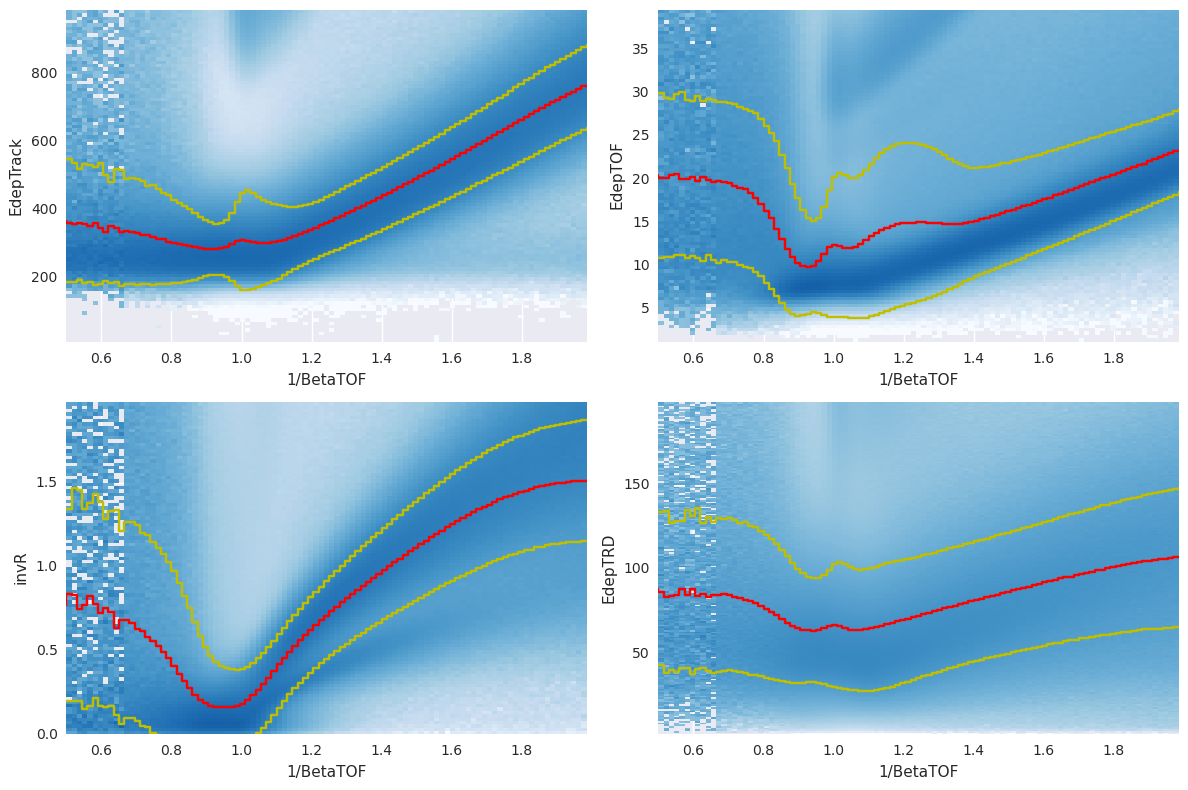

In [26]:
from matplotlib.colors import LogNorm
s.set(rc={'image.cmap': "Blues"})
figsize(12,8)

for n, k in enumerate(frames):
    subplot(2,2,n+1,)
    frame = frames[k]
    frame = frame.set_index(list(frame.columns[:-1])).unstack().fillna(0)['Counts']
    frame /= frame.sum(axis=0)
    plot_matrix(frame, norm=LogNorm(vmin=10**(-5),vmax=1))
    
    
    mean = frame.mul(pd.Series(frame.index,frame.index), axis=0).sum(axis=0)
    std = frame.mul((pd.Series(frame.index,frame.index))**2, axis=0).sum(axis=0)
    std = np.sqrt((std-mean**2))
    
       
    mean.plot(style='r', drawstyle='steps')   
    (mean+std).plot(style='y', drawstyle='steps-post')
    (mean-std).plot(style='y', drawstyle='steps-post')
    
    xlabel("1/BetaTOF")
    ylabel(k)
    
tight_layout()

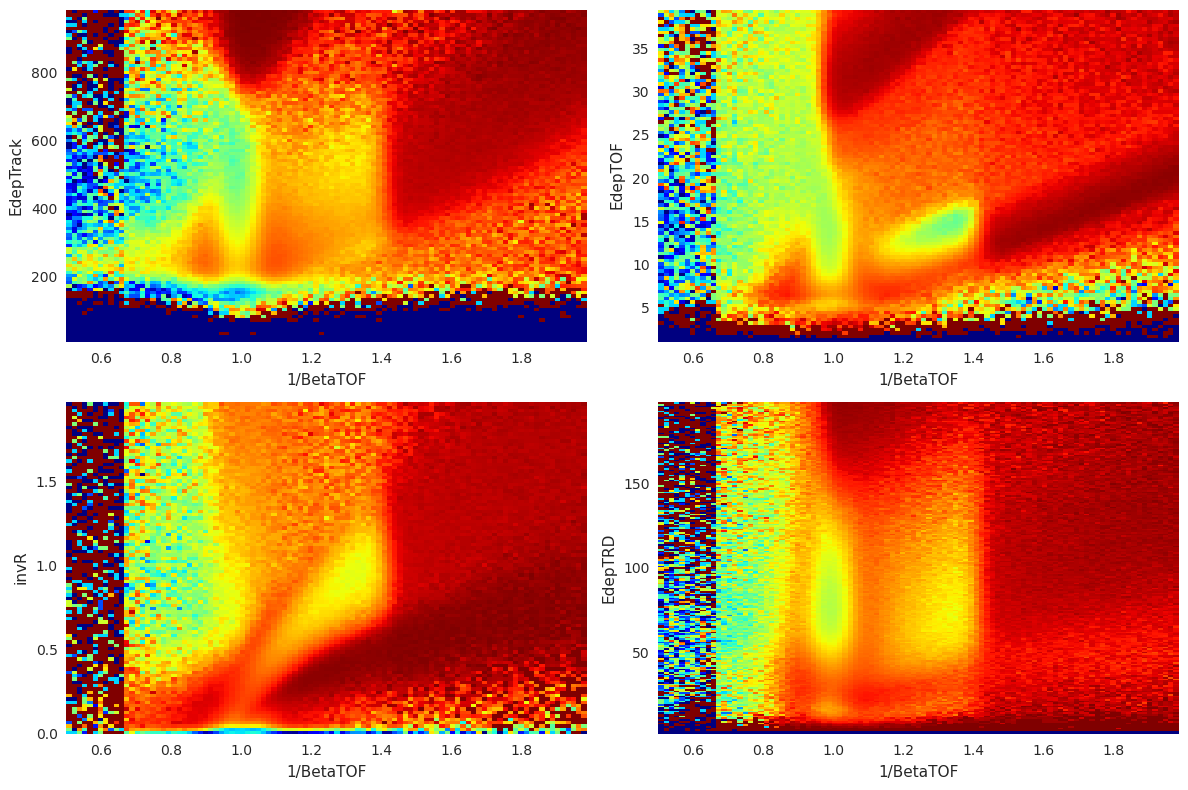

In [42]:
from matplotlib.colors import LogNorm
s.set(rc={'image.cmap': "jet"})
figsize(12,8)

for n, k in enumerate(frames):
    subplot(2,2,n+1,)
    frame = frames[k]
    frame = frame.set_index(list(frame.columns[:-1])).unstack().fillna(0)['Counts']
    #frame /= frame.sum(axis=0)
    frameMC = framesMC[k]
    frameMC = frameMC.set_index(list(frameMC.columns[:-1])).unstack().fillna(0)['Counts']
    #frameMC /= frameMC.sum(axis=0)

    
    plot_matrix((np.abs(frame-frameMC)/(frame+frameMC)).fillna(0))#, norm=LogNorm(vmin=10**(-5),vmax=100))
    xlabel("1/BetaTOF")
    ylabel(k)

tight_layout()